# Semi Supervised Learnign (SSL)

Semi supervised Learning aplica es la machine learning cuando se tienen muy pocos datos etiquetados y partir de estas pocas etiquetas se quiere clasificar un set de datos mucho mayor.

## SELF TRAINING

En los siguientes ejemplos vemos como self training es un método muy sencillo de implementar, pero también puede inducir error si los datos etiquetados no se escogen de manera correcta o la distribución de los datos no es la adecuada para utilzar este método. Tomado de [site](https://stats.stackexchange.com/questions/364584/why-does-using-pseudo-labeling-non-trivially-affect-the-results)

In [5]:
import numpy as np
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
#import seaborn

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
np.random.seed(2018-10-1)
N = 1000

_x = np.linspace(0, np.pi, num=N)
x0 = np.array([_x, np.sin(_x)]).T
x1 = -1 * x0 + [np.pi / 2, 0]

scale = 0.15
x0 += np.random.normal(scale=scale, size=(N, 2))
x1 += np.random.normal(scale=scale, size=(N, 2))

X = np.vstack([x0, x1])

proto_0 = np.array([[0], [0]]).T # the single "labeled" 0
proto_1 = np.array([[np.pi / 2], [0]]).T # the single "labeled" 1


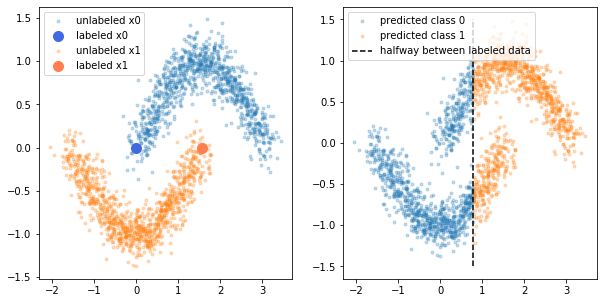

In [33]:
model = RandomForestClassifier()
model.fit(np.vstack([proto_0, proto_1]), np.array([0, 1]))
for itercount in range(100):
    labels = model.predict_proba(X)[:, 0]
    labels += (np.random.random(labels.size) - 0.5) / 10 # add some noise
    labels = labels > 0.5
    model = RandomForestClassifier()
    model.fit(X, labels)

f, axs = plt.subplots(1, 2, squeeze=True, figsize=(10, 5))

axs[0].plot(x0[:, 0], x0[:, 1], '.', alpha=0.25, label='unlabeled x0')
axs[0].plot(proto_0[:, 0], proto_0[:, 1], 'o', color='royalblue', markersize=10, label='labeled x0')
axs[0].plot(x1[:, 0], x1[:, 1], '.', alpha=0.25, label='unlabeled x1')
axs[0].plot(proto_1[:, 0], proto_1[:, 1], 'o', color='coral', markersize=10, label='labeled x1')
axs[0].legend()

axs[1].plot(X[~labels, 0], X[~labels, 1], '.', alpha=0.25, label='predicted class 0')
axs[1].plot(X[labels, 0], X[labels, 1], '.', alpha=0.25, label='predicted class 1')
axs[1].plot([np.pi / 4] * 2, [-1.5, 1.5], 'k--', label='halfway between labeled data')
axs[1].legend()
plt.show()

En las gráficas anteriores se puede ver como solamente con dos puntos el método no es capaz de identificar las clases correctamente

In [88]:
np.random.seed(2018-10-1)
N = 1000


_x = np.linspace(0, 2, num=N)
x0 = np.array([2 + _x, np.random.rand(N)]).T
x1 = np.array([-2 +-1*_x, np.random.rand(N)]).T


scale = 0.15
x0 += np.random.normal(scale=scale, size=(N, 2))
x1 += np.random.normal(scale=scale, size=(N, 2))

X = np.vstack([x0, x1])

proto_0 = np.array([[3], [0.5]]).T # the single "labeled" 0
proto_1 = np.array([[-3], [0.5]]).T # the single "labeled" 1


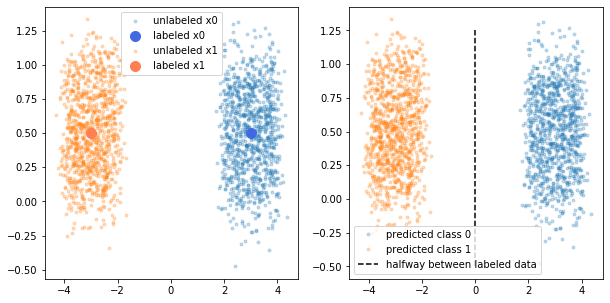

In [92]:
model = RandomForestClassifier()
model.fit(np.vstack([proto_0, proto_1]), np.array([0, 1]))
for itercount in range(100):
    labels = model.predict_proba(X)[:, 0]
    labels += (np.random.random(labels.size) - 0.5) / 10 # add some noise
    labels = labels > 0.5
    model = RandomForestClassifier()
    model.fit(X, labels)

f, axs = plt.subplots(1, 2, squeeze=True, figsize=(10, 5))

axs[0].plot(x0[:, 0], x0[:, 1], '.', alpha=0.25, label='unlabeled x0')
axs[0].plot(proto_0[:, 0], proto_0[:, 1], 'o', color='royalblue', markersize=10, label='labeled x0')
axs[0].plot(x1[:, 0], x1[:, 1], '.', alpha=0.25, label='unlabeled x1')
axs[0].plot(proto_1[:, 0], proto_1[:, 1], 'o', color='coral', markersize=10, label='labeled x1')
axs[0].legend()

axs[1].plot(X[~labels, 0], X[~labels, 1], '.', alpha=0.25, label='predicted class 0')
axs[1].plot(X[labels, 0], X[labels, 1], '.', alpha=0.25, label='predicted class 1')
axs[1].plot([np.pi / 1000] * 2, [-0.5, 1.25], 'k--', label='halfway between labeled data')
axs[1].legend()
plt.show()

En este caso la distribución simple permite que el método sea exitoso.

## LABEL PROPAGATION & LABEL SPREADING

Aplicación de label propagation y label spreding mediante utilizando pytorch.Tomado del [site](https://datascience.stackexchange.com/questions/45459/how-to-use-scikit-learn-label-propagation-on-graph-structured-data)

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from abc import abstractmethod
import torch

class BaseLabelPropagation:
    """Base class for label propagation models.
    
    Parameters
    ----------
    adj_matrix: torch.FloatTensor
        Adjacency matrix of the graph.
    """
    def __init__(self, adj_matrix):
        self.norm_adj_matrix = self._normalize(adj_matrix)
        self.n_nodes = adj_matrix.size(0)
        self.one_hot_labels = None 
        self.n_classes = None
        self.labeled_mask = None
        self.predictions = None

    @staticmethod
    @abstractmethod
    def _normalize(adj_matrix):
        raise NotImplementedError("_normalize must be implemented")

    @abstractmethod
    def _propagate(self):
        raise NotImplementedError("_propagate must be implemented")

    def _one_hot_encode(self, labels):
        # Get the number of classes
        classes = torch.unique(labels)
        classes = classes[classes != -1]
        self.n_classes = classes.size(0)

        # One-hot encode labeled data instances and zero rows corresponding to unlabeled instances
        unlabeled_mask = (labels == -1)
        labels = labels.clone()  # defensive copying
        labels[unlabeled_mask] = 0
        self.one_hot_labels = torch.zeros((self.n_nodes, self.n_classes), dtype=torch.float)
        self.one_hot_labels = self.one_hot_labels.scatter(1, labels.unsqueeze(1), 1)
        self.one_hot_labels[unlabeled_mask, 0] = 0

        self.labeled_mask = ~unlabeled_mask

    def fit(self, labels, max_iter, tol):
        """Fits a semi-supervised learning label propagation model.
        
        labels: torch.LongTensor
            Tensor of size n_nodes indicating the class number of each node.
            Unlabeled nodes are denoted with -1.
        max_iter: int
            Maximum number of iterations allowed.
        tol: float
            Convergence tolerance: threshold to consider the system at steady state.
        """
        self._one_hot_encode(labels)

        self.predictions = self.one_hot_labels.clone()
        prev_predictions = torch.zeros((self.n_nodes, self.n_classes), dtype=torch.float)

        for i in range(max_iter):
            # Stop iterations if the system is considered at a steady state
            variation = torch.abs(self.predictions - prev_predictions).sum().item()
            
            if variation < tol:
                print(f"The method stopped after {i} iterations, variation={variation:.4f}.")
                break

            prev_predictions = self.predictions
            self._propagate()

    def predict(self):
        return self.predictions

    def predict_classes(self):
        return self.predictions.max(dim=1).indices

In [3]:
class LabelPropagation(BaseLabelPropagation):
    def __init__(self, adj_matrix):
        super().__init__(adj_matrix)

    @staticmethod
    def _normalize(adj_matrix):
        """Computes D^-1 * W"""
        degs = adj_matrix.sum(dim=1)
        degs[degs == 0] = 1  # avoid division by 0 error
        return adj_matrix / degs[:, None]

    def _propagate(self):
        self.predictions = torch.matmul(self.norm_adj_matrix, self.predictions)

        # Put back already known labels
        self.predictions[self.labeled_mask] = self.one_hot_labels[self.labeled_mask]

    def fit(self, labels, max_iter=1000, tol=1e-3):
        super().fit(labels, max_iter, tol)

In [4]:
class LabelSpreading(BaseLabelPropagation):
    def __init__(self, adj_matrix):
        super().__init__(adj_matrix)
        self.alpha = None

    @staticmethod
    def _normalize(adj_matrix):
        """Computes D^-1/2 * W * D^-1/2"""
        degs = adj_matrix.sum(dim=1)
        norm = torch.pow(degs, -0.5)
        norm[torch.isinf(norm)] = 1
        return adj_matrix * norm[:, None] * norm[None, :]

    def _propagate(self):
        self.predictions = (
            self.alpha * torch.matmul(self.norm_adj_matrix, self.predictions)
            + (1 - self.alpha) * self.one_hot_labels
        )
    
    def fit(self, labels, max_iter=1000, tol=1e-3, alpha=0.5):
        """
        Parameters
        ----------
        alpha: float
            Clamping factor.
        """
        self.alpha = alpha
        super().fit(labels, max_iter, tol)

In [23]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Create caveman graph
n_cliques = 4
size_cliques = 10
caveman_graph = nx.connected_caveman_graph(n_cliques, size_cliques)
adj_matrix = nx.adjacency_matrix(caveman_graph).toarray()

# Create labels
labels = np.full(n_cliques * size_cliques, -1.,dtype=int)

# Only one node per clique is labeled. Each clique belongs to a different class.
labels[0] = 0
labels[size_cliques] = 1.0
labels[size_cliques * 2] = 2.0
labels[size_cliques * 3] = 3.0

# Create input tensors
adj_matrix = torch.from_numpy(np.array(adj_matrix, dtype=np.float32))
adj_matrix_t = torch.FloatTensor(adj_matrix)
labels_t = torch.LongTensor(labels)

# Learn with Label Propagation
label_propagation = LabelPropagation(adj_matrix_t)
print("Label Propagation: ", end="")
label_propagation.fit(labels_t)
label_propagation_output_labels = label_propagation.predict_classes()

# Learn with Label Spreading
label_spreading = LabelSpreading(adj_matrix_t)
print("Label Spreading: ", end="")
label_spreading.fit(labels_t, alpha=0.8)
label_spreading_output_labels = label_spreading.predict_classes()

Label Propagation: The method stopped after 73 iterations, variation=0.0010.
Label Spreading: The method stopped after 20 iterations, variation=0.0009.


C:\Users\ajrodr4\AppData\Local\Continuum\anaconda3\envs\Inv-Corta-1\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


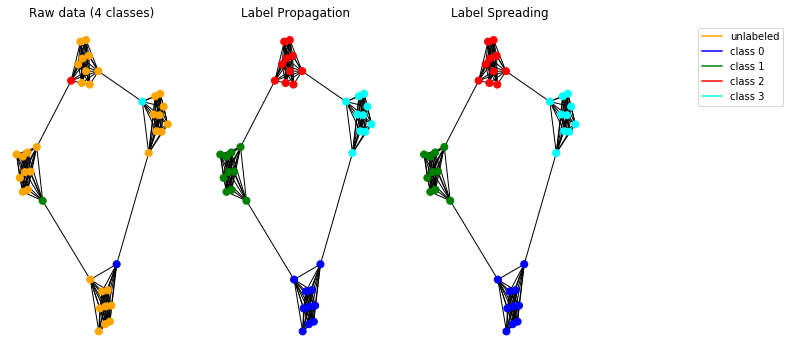

In [24]:
# Plot graphs
color_map = {-1: "orange", 0: "blue", 1: "green", 2: "red", 3: "cyan"}
input_labels_colors = [color_map[l] for l in labels]
lprop_labels_colors = [color_map[l] for l in label_propagation_output_labels.numpy()]
lspread_labels_colors = [color_map[l] for l in label_spreading_output_labels.numpy()]

plt.figure(figsize=(14, 6))
ax1 = plt.subplot(1, 4, 1)
ax2 = plt.subplot(1, 4, 2)
ax3 = plt.subplot(1, 4, 3)

ax1.title.set_text("Raw data (4 classes)")
ax2.title.set_text("Label Propagation")
ax3.title.set_text("Label Spreading")

pos = nx.spring_layout(caveman_graph)
nx.draw(caveman_graph, ax=ax1, pos=pos, node_color=input_labels_colors, node_size=50)
nx.draw(caveman_graph, ax=ax2, pos=pos, node_color=lprop_labels_colors, node_size=50)
nx.draw(caveman_graph, ax=ax3, pos=pos, node_color=lspread_labels_colors, node_size=50)

# Legend
ax4 = plt.subplot(1, 4, 4)
ax4.axis("off")
legend_colors = ["orange", "blue", "green", "red", "cyan"]
legend_labels = ["unlabeled", "class 0", "class 1", "class 2", "class 3"]
dummy_legend = [ax4.plot([], [], ls='-', c=c)[0] for c in legend_colors]
plt.legend(dummy_legend, legend_labels)

plt.show()

## LABEL PROPAGATION scikit learning aplicado a imágenes

Ejemplo de como se puede usilizar label propagation en imágenes con pocos datos etiquetados. Tomado de tomado de [site](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-digits-py)

Automatically created module for IPython interactive environment
Label Spreading model: 40 labeled & 300 unlabeled points (340 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.82      1.00      0.90        37
           2       1.00      0.86      0.92        28
           3       1.00      0.80      0.89        35
           4       0.92      1.00      0.96        24
           5       0.74      0.94      0.83        34
           6       0.89      0.96      0.92        25
           7       0.94      0.89      0.91        35
           8       1.00      0.68      0.81        31
           9       0.81      0.88      0.84        24

    accuracy                           0.90       300
   macro avg       0.91      0.90      0.90       300
weighted avg       0.91      0.90      0.90       300

Confusion matrix
[[27  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  1 24  0  0  0  2  

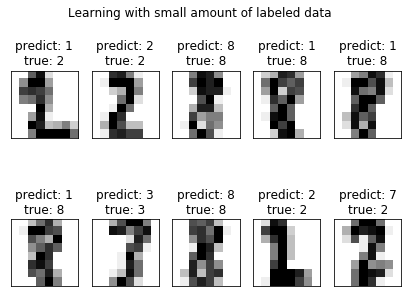

In [77]:
print(__doc__)

# Authors: Clay Woolam <clay@woolam.org>
# License: BSD

import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from sklearn import datasets
from sklearn.semi_supervised import label_propagation

from sklearn.metrics import confusion_matrix, classification_report

digits = datasets.load_digits()
rng = np.random.RandomState(2)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

X = digits.data[indices[:340]]
y = digits.target[indices[:340]]
images = digits.images[indices[:340]]

n_total_samples = len(y)
n_labeled_points = 40

indices = np.arange(n_total_samples)

unlabeled_set = indices[n_labeled_points:]

# #############################################################################
# Shuffle everything around
y_train = np.copy(y)
y_train[unlabeled_set] = -1

# #############################################################################
# Learn with LabelSpreading
lp_model = label_propagation.LabelSpreading(gamma=.25, max_iter=20)
lp_model.fit(X, y_train)
predicted_labels = lp_model.transduction_[unlabeled_set]
true_labels = y[unlabeled_set]

cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

print("Label Spreading model: %d labeled & %d unlabeled points (%d total)" %
      (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

print(classification_report(true_labels, predicted_labels))

print("Confusion matrix")
print(cm)

# #############################################################################
# Calculate uncertainty values for each transduced distribution
pred_entropies = stats.distributions.entropy(lp_model.label_distributions_.T)

# #############################################################################
# Pick the top 10 most uncertain labels
uncertainty_index = np.argsort(pred_entropies)[-10:]

# #############################################################################
# Plot
f = plt.figure(figsize=(7, 5))
for index, image_index in enumerate(uncertainty_index):
    image = images[image_index]

    sub = f.add_subplot(2, 5, index + 1)
    sub.imshow(image, cmap=plt.cm.gray_r)
    plt.xticks([])
    plt.yticks([])
    sub.set_title('predict: %i\ntrue: %i' % (
        lp_model.transduction_[image_index], y[image_index]))

f.suptitle('Learning with small amount of labeled data')
plt.show()

## Label propagation utilizando knn

Tomado de [site](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_structure.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-structure-py)

Automatically created module for IPython interactive environment


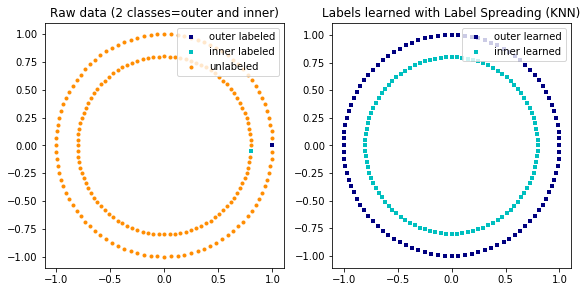

In [78]:
print(__doc__)

# Authors: Clay Woolam <clay@woolam.org>
#          Andreas Mueller <amueller@ais.uni-bonn.de>
# License: BSD

import numpy as np
import matplotlib.pyplot as plt
from sklearn.semi_supervised import label_propagation
from sklearn.datasets import make_circles

# generate ring with inner box
n_samples = 200
X, y = make_circles(n_samples=n_samples, shuffle=False)
outer, inner = 0, 1
labels = np.full(n_samples, -1.)
labels[0] = outer
labels[-1] = inner

# #############################################################################
# Learn with LabelSpreading
label_spread = label_propagation.LabelSpreading(kernel='knn', alpha=0.8)
label_spread.fit(X, labels)

# #############################################################################
# Plot output labels
output_labels = label_spread.transduction_
plt.figure(figsize=(8.5, 4))
plt.subplot(1, 2, 1)
plt.scatter(X[labels == outer, 0], X[labels == outer, 1], color='navy',
            marker='s', lw=0, label="outer labeled", s=10)
plt.scatter(X[labels == inner, 0], X[labels == inner, 1], color='c',
            marker='s', lw=0, label='inner labeled', s=10)
plt.scatter(X[labels == -1, 0], X[labels == -1, 1], color='darkorange',
            marker='.', label='unlabeled')
plt.legend(scatterpoints=1, shadow=False, loc='upper right')
plt.title("Raw data (2 classes=outer and inner)")

plt.subplot(1, 2, 2)
output_label_array = np.asarray(output_labels)
outer_numbers = np.where(output_label_array == outer)[0]
inner_numbers = np.where(output_label_array == inner)[0]
plt.scatter(X[outer_numbers, 0], X[outer_numbers, 1], color='navy',
            marker='s', lw=0, s=10, label="outer learned")
plt.scatter(X[inner_numbers, 0], X[inner_numbers, 1], color='c',
            marker='s', lw=0, s=10, label="inner learned")
plt.legend(scatterpoints=1, shadow=False, loc='upper right')
plt.title("Labels learned with Label Spreading (KNN)")

plt.subplots_adjust(left=0.07, bottom=0.07, right=0.93, top=0.92)
plt.show()

# LABEL PROPAGATION VS SVM

Tomado de [site](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_versus_svm_iris.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-versus-svm-iris-py)

Automatically created module for IPython interactive environment


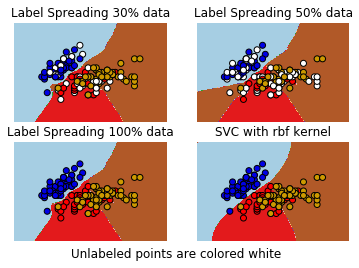

In [79]:
print(__doc__)

# Authors: Clay Woolam <clay@woolam.org>
# License: BSD

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
from sklearn.semi_supervised import label_propagation

rng = np.random.RandomState(0)

iris = datasets.load_iris()

X = iris.data[:, :2]
y = iris.target

# step size in the mesh
h = .02

y_30 = np.copy(y)
y_30[rng.rand(len(y)) < 0.3] = -1
y_50 = np.copy(y)
y_50[rng.rand(len(y)) < 0.5] = -1
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
ls30 = (label_propagation.LabelSpreading().fit(X, y_30),
        y_30)
ls50 = (label_propagation.LabelSpreading().fit(X, y_50),
        y_50)
ls100 = (label_propagation.LabelSpreading().fit(X, y), y)
rbf_svc = (svm.SVC(kernel='rbf', gamma=.5).fit(X, y), y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['Label Spreading 30% data',
          'Label Spreading 50% data',
          'Label Spreading 100% data',
          'SVC with rbf kernel']

color_map = {-1: (1, 1, 1), 0: (0, 0, .9), 1: (1, 0, 0), 2: (.8, .6, 0)}

for i, (clf, y_train) in enumerate((ls30, ls50, ls100, rbf_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis('off')

    # Plot also the training points
    colors = [color_map[y] for y in y_train]
    plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='black')

    plt.title(titles[i])

plt.suptitle("Unlabeled points are colored white", y=0.1)
plt.show()

# Pseudo-labeling 

Uso de pseudo-labeling y comparación de varios método de regresión. Tomado del [site](https://datawhatnow.com/pseudo-labeling-semi-supervised-learning/)

In [5]:
import pandas as pd

In [6]:
train = pd.read_csv('mercedes_benz_train.csv')
test = pd.read_csv('mercedes_benz_test.csv')

print(train.shape, test.shape)

(4209, 378) (4209, 377)


In [7]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [9]:
features = train.columns[2:]

for column_name in features:
    label_encoder = LabelEncoder() 
    
    # Get the column values
    train_column_values = list(train[column_name].values)
    test_column_values = list(test[column_name].values)
    
    # Fit the label encoder
    label_encoder.fit(train_column_values + test_column_values)
    
    # Transform the feature
    train[column_name] = label_encoder.transform(train_column_values)
    test[column_name] = label_encoder.transform(test_column_values)
    
train[train.columns[:12]].head(3)

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11
0,0,130.81,37,23,20,0,3,27,9,14,0,0
1,6,88.53,37,21,22,4,3,31,11,14,0,0
2,7,76.26,24,24,38,2,3,30,9,23,0,0


In [10]:
target = 'y'

X_train, X_test = train[features], test[features]
y_train = train[target]

In [3]:
from xgboost import XGBRegressor
from sklearn.linear_model import BayesianRidge, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [11]:
model_factory = [
    RandomForestRegressor(),
    XGBRegressor(nthread=1),
    MLPRegressor(),
    Ridge(),
    BayesianRidge(),
    ExtraTreesRegressor(),
    ElasticNet(),
    KNeighborsRegressor(),
    GradientBoostingRegressor()
]

for model in model_factory:
    model.seed = 42
    num_folds = 3

    scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='r2', n_jobs=8)
    score_description = " %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

    print('{model:25} CV-5 R2: {score}'.format(
        model=model.__class__.__name__,
        score=score_description
    ))

RandomForestRegressor     CV-5 R2:  0.45 (+/- 0.02)
XGBRegressor              CV-5 R2:  0.55 (+/- 0.06)
MLPRegressor              CV-5 R2:  0.52 (+/- 0.08)
Ridge                     CV-5 R2:  0.52 (+/- 0.08)
BayesianRidge             CV-5 R2:  0.54 (+/- 0.07)
ExtraTreesRegressor       CV-5 R2:  0.36 (+/- 0.05)
ElasticNet                CV-5 R2:  0.35 (+/- 0.06)
KNeighborsRegressor       CV-5 R2:  0.27 (+/- 0.04)
GradientBoostingRegressor CV-5 R2:  0.53 (+/- 0.06)


In [12]:

from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin

class PseudoLabeler(BaseEstimator, RegressorMixin):
    '''
    Sci-kit learn wrapper for creating pseudo-lebeled estimators.
    '''
    
    def __init__(self, model, unlabled_data, features, target, sample_rate=0.2, seed=42):
        '''
        @sample_rate - percent of samples used as pseudo-labelled data
                       from the unlabled dataset
        '''
        assert sample_rate <= 1.0, 'Sample_rate should be between 0.0 and 1.0.'
        
        self.sample_rate = sample_rate
        self.seed = seed
        self.model = model
        self.model.seed = seed
        
        self.unlabled_data = unlabled_data
        self.features = features
        self.target = target
        
    def get_params(self, deep=True):
        return {
            "sample_rate": self.sample_rate,
            "seed": self.seed,
            "model": self.model,
            "unlabled_data": self.unlabled_data,
            "features": self.features,
            "target": self.target
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

        
    def fit(self, X, y):
        '''
        Fit the data using pseudo labeling.
        '''

        augemented_train = self.__create_augmented_train(X, y)
        self.model.fit(
            augemented_train[self.features],
            augemented_train[self.target]
        )
        
        return self


    def __create_augmented_train(self, X, y):
        '''
        Create and return the augmented_train set that consists
        of pseudo-labeled and labeled data.
        '''        
        num_of_samples = int(len(self.unlabled_data) * self.sample_rate)
        
        # Train the model and creat the pseudo-labels
        self.model.fit(X, y)
        pseudo_labels = self.model.predict(self.unlabled_data[self.features])
        
        # Add the pseudo-labels to the test set
        pseudo_data = self.unlabled_data.copy(deep=True)
        pseudo_data[self.target] = pseudo_labels
        
        # Take a subset of the test set with pseudo-labels and append in onto
        # the training set
        sampled_pseudo_data = pseudo_data.sample(n=num_of_samples)
        temp_train = pd.concat([X, y], axis=1)
        augemented_train = pd.concat([sampled_pseudo_data, temp_train])

        return shuffle(augemented_train)
        
    def predict(self, X):
        '''
        Returns the predicted values.
        '''
        return self.model.predict(X)
    
    def get_model_name(self):
        return self.model.__class__.__name__

In [13]:
model = PseudoLabeler(
    XGBRegressor(nthread=1),
    test,
    features,
    target
)

model.fit(X_train, y_train)
model.predict(X_train)

[23:09:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\ajrodr4\AppData\Local\Continuum\anaconda3\envs\Inv-Corta-1\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ajrodr4\AppData\Local\Continuum\anaconda3\envs\Inv-Corta-1\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
C:\Users\ajrodr4\AppData\Local\Continuum\anaconda3\envs\Inv-Corta-1\lib\site-packages\ipykernel_launcher.py:75: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[23:09:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([117.57491,  91.81469,  76.20285, ..., 110.54349,  92.13165,
        94.21528], dtype=float32)

In [14]:
model_factory = [
    XGBRegressor(nthread=1),
    
    PseudoLabeler(
        XGBRegressor(nthread=1),
        test,
        features,
        target,
        sample_rate=0.3
    ),
]

for model in model_factory:
    model.seed = 42
    num_folds = 8
    
    scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='r2', n_jobs=8)
    score_description = "R2: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2)

    print('{model:25} CV-{num_folds} {score_cv}'.format(
        model=model.__class__.__name__,
        num_folds=num_folds,
        score_cv=score_description
    ))

XGBRegressor              CV-8 R2: 0.5671 (+/- 0.1596)
PseudoLabeler             CV-8 R2: 0.5691 (+/- 0.1582)


In [15]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [16]:
sample_rates = np.linspace(0, 1, 10)

def pseudo_label_wrapper(model):
    return PseudoLabeler(model, test, features, target)

# List of all models to test
model_factory = [
    RandomForestRegressor(n_jobs=1),
    XGBRegressor(),
    MLPRegressor(),
    Ridge(),
    BayesianRidge(),
    ExtraTreesRegressor(n_jobs=1),
    ElasticNet(),
    KNeighborsRegressor(),
    GradientBoostingRegressor()
]

# Apply the PseudoLabeler class to each model
model_factory = map(pseudo_label_wrapper, model_factory)

# Train each model with different sample rates
results = {}
num_folds = 5

for model in model_factory:
    model_name = model.get_model_name()
    print('%s' % model_name)

    results[model_name] = list()
    for sample_rate in sample_rates:
        model.sample_rate = sample_rate
        
        # Calculate the CV-3 R2 score and store it
        scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='r2', n_jobs=8)
        results[model_name].append(scores.mean())

RandomForestRegressor
XGBRegressor
MLPRegressor
Ridge
BayesianRidge
ExtraTreesRegressor
ElasticNet
KNeighborsRegressor
GradientBoostingRegressor


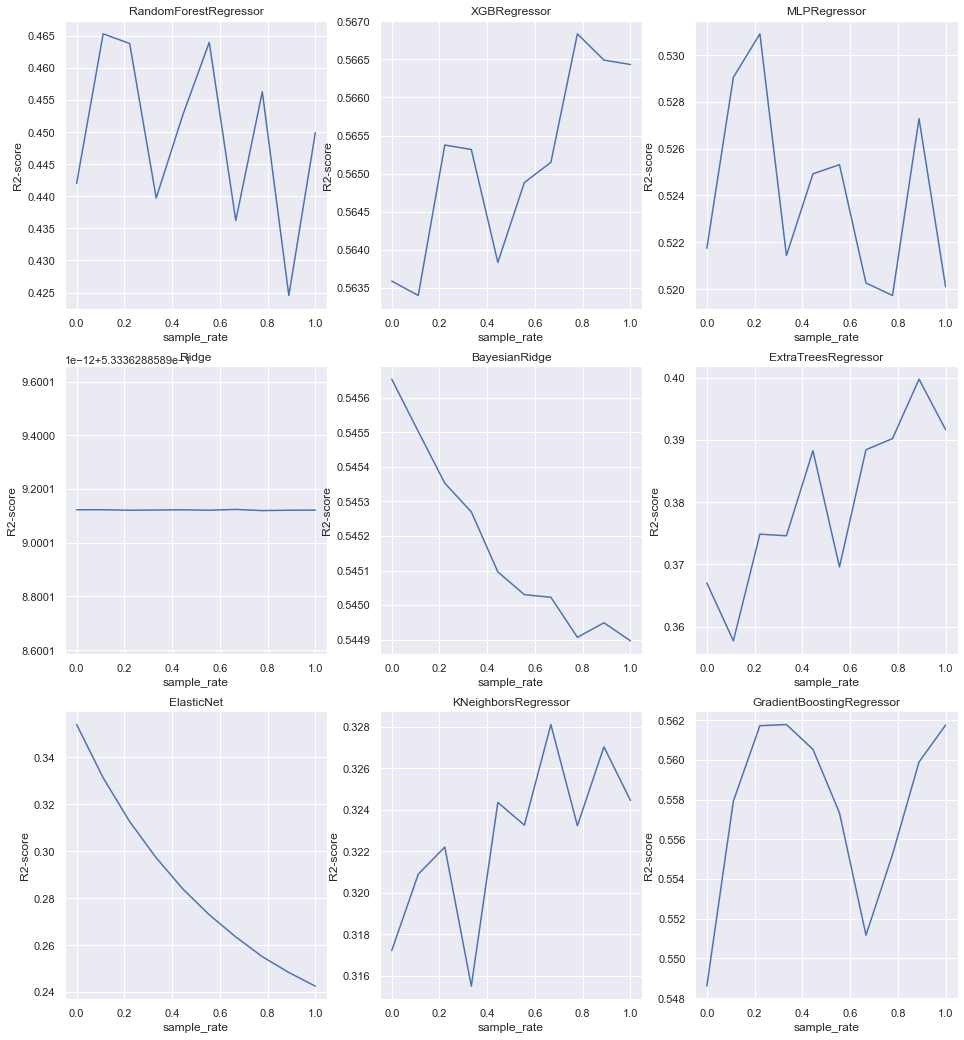

In [17]:
plt.figure(figsize=(16, 18))

i = 1
for model_name, performance in results.items():    
    plt.subplot(3, 3, i)
    i += 1
    
    plt.plot(sample_rates, performance)
    plt.title(model_name)
    plt.xlabel('sample_rate')
    plt.ylabel('R2-score')
    

plt.show()